# Chapter 4: Classification using Naive Bayes --------------------

## Example: Filtering spam SMS messages ----
## Step 2: Exploring and preparing the data ---- 

In [1]:
# read the sms data into the sms data frame
sms_raw <- read.csv("sms_spam.csv", stringsAsFactors = FALSE)

In [2]:
# examine the structure of the sms data
str(sms_raw)

'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline "| __truncated__ ...


In [3]:
# convert spam/ham to factor.
sms_raw$type <- factor(sms_raw$type)

In [4]:
# examine the type variable more carefully
str(sms_raw$type)
table(sms_raw$type)

 Factor w/ 2 levels "ham","spam": 1 1 1 2 2 1 1 1 2 1 ...



 ham spam 
4812  747 

In [5]:
# install the tm package
install.packages("tm")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
also installing the dependencies ‘NLP’, ‘slam’



In [6]:
# build a corpus using the text mining (tm) package
library(tm)
sms_corpus <- VCorpus(VectorSource(sms_raw$text))

Loading required package: NLP


In [7]:
# examine the sms corpus
print(sms_corpus)
inspect(sms_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5559
<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 49

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 23



In [8]:
as.character(sms_corpus[[1]])
lapply(sms_corpus[1:2], as.character)

[1] "Hope you are having a good week. Just checking in"

$`1`
[1] "Hope you are having a good week. Just checking in"

$`2`
[1] "K..give back my thanks."

In [9]:
# clean up the corpus using tm_map()
sms_corpus_clean <- tm_map(sms_corpus, content_transformer(tolower))

In [10]:
# show the difference between sms_corpus and corpus_clean
as.character(sms_corpus[[1]])
as.character(sms_corpus_clean[[1]])

[1] "Hope you are having a good week. Just checking in"

[1] "hope you are having a good week. just checking in"

In [11]:
sms_corpus_clean <- tm_map(sms_corpus_clean, removeNumbers) # remove numbers
sms_corpus_clean <- tm_map(sms_corpus_clean, removeWords, stopwords()) # remove stop words
sms_corpus_clean <- tm_map(sms_corpus_clean, removePunctuation) # remove punctuation

In [12]:
# tip: create a custom function to replace (rather than remove) punctuation
removePunctuation("hello...world")
replacePunctuation <- function(x) { gsub("[[:punct:]]+", " ", x) }
replacePunctuation("hello...world")

[1] "helloworld"

[1] "hello world"

In [14]:
# install the SnowballC package
install.packages("SnowballC")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [15]:
# illustration of word stemming
library(SnowballC)
wordStem(c("learn", "learned", "learning", "learns"))

[1] "learn" "learn" "learn" "learn"

In [16]:
sms_corpus_clean <- tm_map(sms_corpus_clean, stemDocument)
sms_corpus_clean <- tm_map(sms_corpus_clean, stripWhitespace) # eliminate unneeded whitespace

In [17]:
# examine the final clean corpus
lapply(sms_corpus[1:3], as.character)
lapply(sms_corpus_clean[1:3], as.character)

$`1`
[1] "Hope you are having a good week. Just checking in"

$`2`
[1] "K..give back my thanks."

$`3`
[1] "Am also doing in cbe only. But have to pay."

$`1`
[1] "hope good week just check"

$`2`
[1] "kgive back thank"

$`3`
[1] "also cbe pay"

In [18]:
# create a document-term sparse matrix
sms_dtm <- DocumentTermMatrix(sms_corpus_clean)

In [19]:
# alternative solution: create a document-term sparse matrix directly from the SMS corpus
sms_dtm2 <- DocumentTermMatrix(sms_corpus, control = list(
  tolower = TRUE,
  removeNumbers = TRUE,
  stopwords = TRUE,
  removePunctuation = TRUE,
  stemming = TRUE
))

In [20]:
# alternative solution: using custom stop words function ensures identical result
sms_dtm3 <- DocumentTermMatrix(sms_corpus, control = list(
  tolower = TRUE,
  removeNumbers = TRUE,
  stopwords = function(x) { removeWords(x, stopwords()) },
  removePunctuation = TRUE,
  stemming = TRUE
))

In [21]:
# compare the result
sms_dtm
sms_dtm2
sms_dtm3

<<DocumentTermMatrix (documents: 5559, terms: 6559)>>
Non-/sparse entries: 42147/36419334
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5559, terms: 6961)>>
Non-/sparse entries: 43221/38652978
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5559, terms: 6559)>>
Non-/sparse entries: 42147/36419334
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [22]:
# creating training and test datasets
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test  <- sms_dtm[4170:5559, ]

In [23]:
# also save the labels
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels  <- sms_raw[4170:5559, ]$type

In [24]:
# check that the proportion of spam is similar
prop.table(table(sms_train_labels))
prop.table(table(sms_test_labels))

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

sms_test_labels
      ham      spam 
0.8683453 0.1316547 

In [25]:
# install the wordcloud package
install.packages("wordcloud")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


Loading required package: RColorBrewer


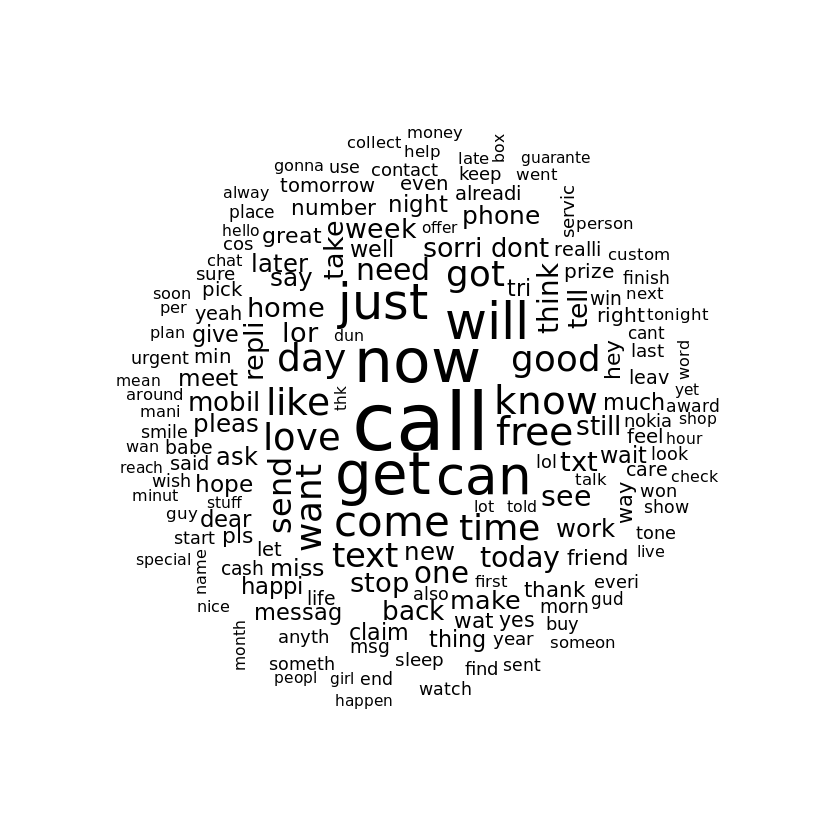

In [26]:
# word cloud visualization
library(wordcloud)
wordcloud(sms_corpus_clean, min.freq = 50, random.order = FALSE)

In [27]:
# subset the training data into spam and ham groups
spam <- subset(sms_raw, type == "spam")
ham  <- subset(sms_raw, type == "ham")

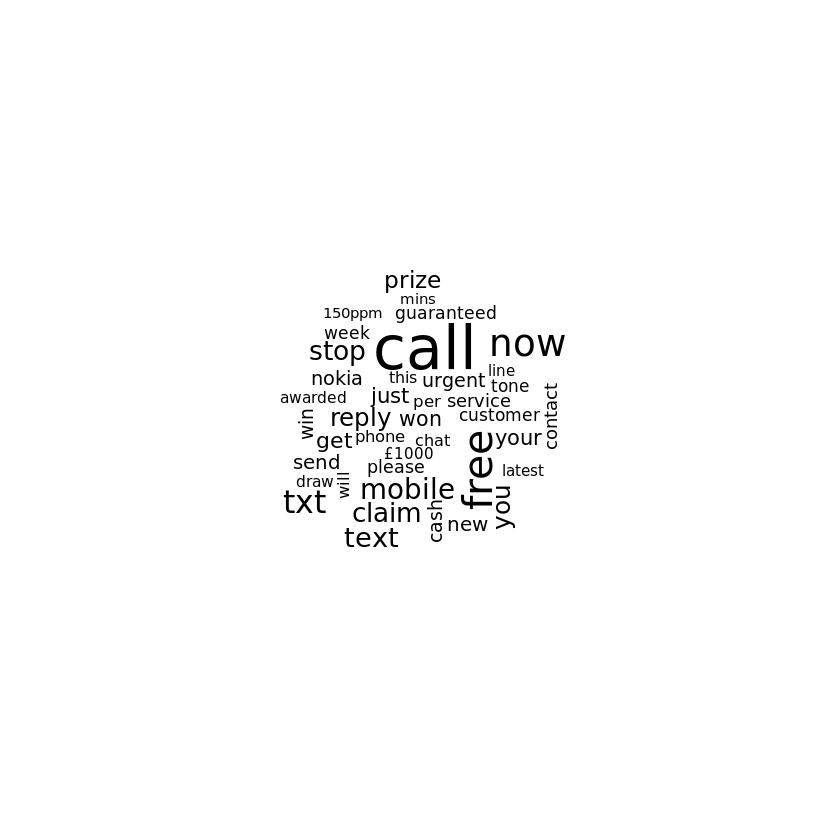

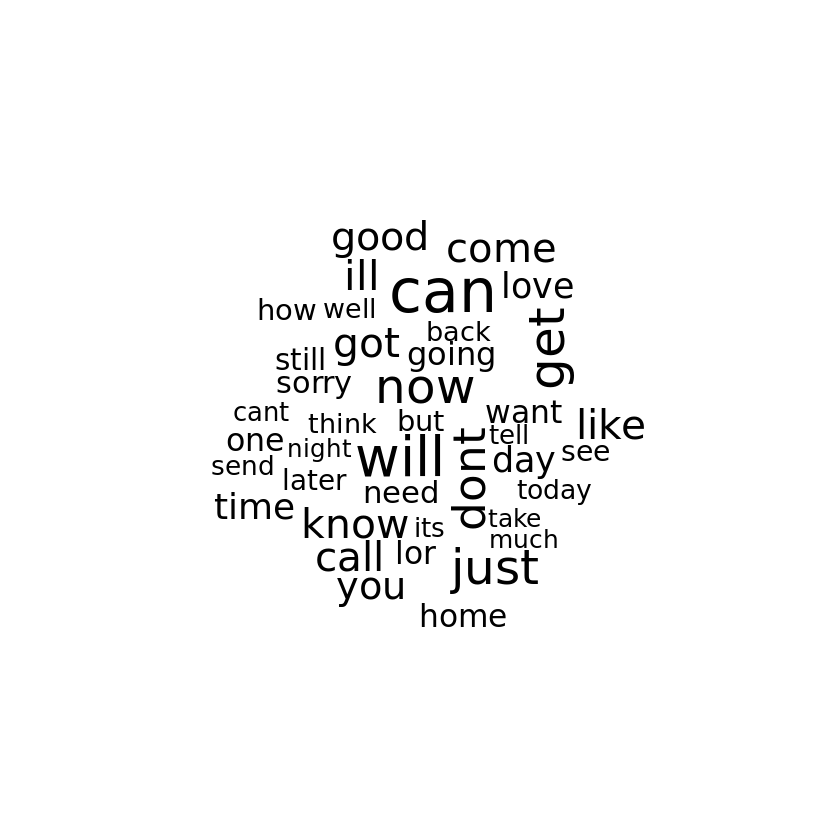

In [28]:
wordcloud(spam$text, max.words = 40, scale = c(3, 0.5))
wordcloud(ham$text, max.words = 40, scale = c(3, 0.5))

In [29]:
sms_dtm_freq_train <- removeSparseTerms(sms_dtm_train, 0.999)
sms_dtm_freq_train

<<DocumentTermMatrix (documents: 4169, terms: 1104)>>
Non-/sparse entries: 24827/4577749
Sparsity           : 99%
Maximal term length: 19
Weighting          : term frequency (tf)

In [30]:
# indicator features for frequent words
findFreqTerms(sms_dtm_train, 5)

[1] "£wk"                 "€˜m"                 "€˜s"                
   [4] "abiola"              "abl"                 "abt"                
   [7] "accept"              "access"              "account"            
  [10] "across"              "act"                 "activ"              
  [13] "actual"              "add"                 "address"            
  [16] "admir"               "adult"               "advanc"             
  [19] "aft"                 "afternoon"           "age"                
  [22] "ago"                 "aha"                 "ahead"              
  [25] "aight"               "aint"                "air"                
  [28] "aiyo"                "alex"                "almost"             
  [31] "alon"                "alreadi"             "alright"            
  [34] "also"                "alway"               "angri"              
  [37] "announc"             "anoth"               "answer"             
  [40] "anymor"              "anyon"               "anyth"              
  [43] "anytim"              "anyway"              "apart"              
  [46] "app"                 "appli"               "appreci"            
  [49] "arcad"               "ard"                 "area"               
  [52] "argu"                "argument"            "armand"             
  [55] "around"              "arrang"              "arriv"              
  [58] "asap"                "ask"                 "askd"               
  [61] "attempt"             "auction"             "avail"              
  [64] "ave"                 "avoid"               "await"              
  [67] "awak"                "award"               "away"               
  [70] "awesom"              "babe"                "babi"               
  [73] "back"                "bad"                 "bag"                
  [76] "bank"                "bare"                "basic"              
  [79] "bath"                "batteri"             "bcoz"               
  [82] "bday"                "beauti"              "becom"              
  [85] "bed"                 "bedroom"             "beer"               
  [88] "begin"               "believ"              "best"               
  [91] "better"              "bid"                 "big"                
  [94] "bill"                "bird"                "birthday"           
  [97] "bit"                 "black"               "blank"              
 [100] "bless"               "blue"                "bluetooth"          
 [103] "bold"                "bonus"               "boo"                
 [106] "book"                "boost"               "bore"               
 [109] "boss"                "bother"              "bout"               
 [112] "box"                 "boy"                 "boytoy"             
 [115] "break"               "breath"              "bring"              
 [118] "brother"             "bslvyl"              "btnationalr"        
 [121] "buck"                "bus"                 "busi"               
 [124] "buy"                 "cabin"               "call"               
 [127] "caller"              "callertun"           "camcord"            
 [130] "came"                "camera"              "campus"             
 [133] "can"                 "cancel"              "cancer"             
 [136] "cant"                "car"                 "card"               
 [139] "care"                "carlo"               "case"               
 [142] "cash"                "cashbal"             "catch"              
 [145] "caus"                "celebr"              "cell"               
 [148] "centr"               "chanc"               "chang"              
 [151] "charg"               "chat"                "cheap"              
 [154] "cheaper"             "check"               "cheer"              
 [157] "chennai"             "chikku"              "childish"           
 [160] "children"            "choic"               "choos"              
 [163] "christma"            "claim"               "class"   

In [31]:
# save frequently-appearing terms to a character vector
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)
str(sms_freq_words)

 chr [1:1139] "£wk" "€˜m" "€˜s" "abiola" "abl" "abt" "accept" "access" ...


In [32]:
# create DTMs with only the frequent terms
sms_dtm_freq_train <- sms_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- sms_dtm_test[ , sms_freq_words]

In [33]:
# convert counts to a factor
convert_counts <- function(x) {
  x <- ifelse(x > 0, "Yes", "No")
}

In [34]:
# apply() convert_counts() to columns of train/test data
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test  <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)

## Step 3: Training a model on the data ----

In [35]:
# install the e1071 package
install.packages("e1071")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [36]:
library(e1071)
sms_classifier <- naiveBayes(sms_train, sms_train_labels)

## Step 4: Evaluating model performance ----

In [37]:
sms_test_pred <- predict(sms_classifier, sms_test)

In [38]:
# install the gmodels package
install.packages("gmodels")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [39]:
library(gmodels)
CrossTable(sms_test_pred, sms_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1201 |        30 |      1231 | 
             |     0.995 |     0.164 |           | 
-------------|-----------|-----------|-----------|
        spam |         6 |       153 |       159 | 
             |     0.005 |     0.836 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


## Step 5: Improving model performance ----

In [40]:
sms_classifier2 <- naiveBayes(sms_train, sms_train_labels, laplace = 1)
sms_test_pred2 <- predict(sms_classifier2, sms_test)
CrossTable(sms_test_pred2, sms_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        28 |      1230 | 
             |     0.996 |     0.153 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       155 |       160 | 
             |     0.004 |     0.847 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 
